<a href="https://colab.research.google.com/github/YB-Sung/DXIC_Lab_18_Semi-Supervised-Learning/blob/main/20_2_Consistency_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번 실습에서는 Semi Supervised Learning 분야의 Consistency Regularization 방법론 중 UDA, Mean Teacher, $\Pi$ Model를 다뤄보도록 하겠습니다.
각 방법론의 특징을 환기 차원에서 정리하면 아래와 같습니다.

# 방법론 별 특징
## $\Pi$ Model
- 하나의 모델에 대해 labeled data에 대해서는 **CE Loss**로 학습이 진행됩니다.
- Unlabeled data에 대해서는 두개의 augmentation을 각각 입력으로 하여 **두 번의 fowarding**을 수행합니다.
- 서로 다른 augmentation에 대해 동일한 **representation**을 수행하도록 하는 MSE Loss를 학습합니다.

## Mean Teacher
- 학습을 통해 업데이트되는 모델(Student Model)과 별도의 Teacher Model을 이용합니다.
- Teacher Model은 Student Model의 Weight를 **Moving Averaging**하여 사용합니다.
- Student Model의 학습은 Labeled 데이터를 통한 CE Loss와 Teacher Model과 비슷한 출력을 산출하는 MSE Loss를 통해 학습됩니다.
- 이때, 두 모델의 Unlabeled Data 입력은 **Augmentation**을 이용하여 구성합니다.

## UDA
- Labeled Data에 대해 CE Loss로 학습이 진행됩니다.
- Unlabeled Data에 대하여 **Augmentation 여부**에 따라 2가지 입력을 구성합니다.
- 동일 모델에 대해 Augmentation 여부에 따른 **예측값**을 도출합니다.
- **두 예측값이 같은 분포**(같은 예측 확률)를 가지도록 KL Divergence를 통해 Consistency Loss로 학습이 진행됩니다.


# 실습 순서
이번 실습은 아래와 같은 순서로 진행됩니다.
1. 데이터셋 전처리 및 EDA 진행
2. 공통 사용 함수 정의 (model, dataloader, augmentation, loss function 등)
3. $\Pi$ Model 알고리즘 구현
4. Mean Teacher 알고리즘 구현
5. UDA 알고리즘 구현
6. 전체 학습 파이프라인 구현
7. 각 알고리즘 학습 및 성능 비교

In [ ]:
!pip install datasets

In [ ]:
import torch
import torch.utils.checkpoint
from torch import Tensor, nn
from torch.nn import CrossEntropyLoss
from torchvision.transforms.v2 import Compose, RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomVerticalFlip, ToTensor, RandAugment, ToDtype, Resize
from transformers import AutoFeatureExtractor, AutoConfig, AutoModel
from datasets import load_dataset


from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# 시드 고정
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

# 1. 데이터셋 전처리 및 EDA

이번 실습에서는 이진분류 문제를 다뤄보도록 하겠습니다.
활용할 데이터셋은 개와 음식 사진을 구별하는 데이터셋입니다.
머핀이나 치킨과 비슷하게 생긴 강아지 사진과 실제 머핀 및 치킨 사진을 구별하는 문제입니다.

## 1-1. Data 다운로드 및 예시
온라인 상에 공개되어 있는 데이터를 쉽게 다운받을 수 있도록 도와주는 HuggingFace 사의 Datasets 라이브러리를 이용하여 데이터를 다운로드 받습니다.
(https://huggingface.co/datasets/sasha/dog-food)

In [ ]:
## 데이터 다운로드 시 1분 이내의 시간이 소요됩니다.
dataset = load_dataset("sasha/dog-food")

## 해당 데이터셋은 Train/Test로 구성되어 있습니다. 이를 우선 분리하겠습니다.
train_dataset = list(dataset["train"])
test_dataset = list(dataset["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Text(0.5, 1.0, '머핀 이미지')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47672 (\N{HANGUL SYLLABLE MEO}) missing from current font.
  func(*args, *

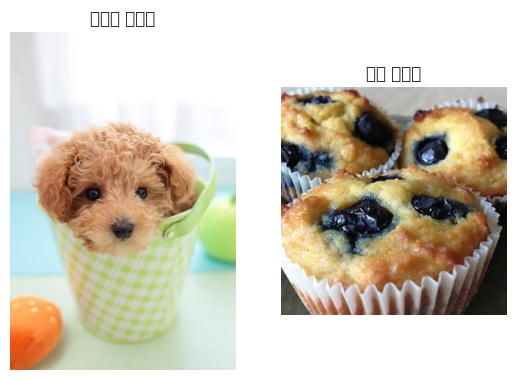

In [ ]:
## 실제 강아지와 음식 사진 예시입니다.
### 강아지 사진은 푸들이 주를 이루고, 음식 사진은 머핀과 치킨이 주를 이루게 됩니다.
plt.subplot(1,2,1)
plt.imshow(train_dataset[3]['image'])
plt.title("강아지 이미지")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_dataset[-2]['image'])
plt.axis('off')
plt.title("머핀 이미지")


우리가 보는 이미지는 모두 행렬 형식으로 구성되어, 컴퓨터에서 처리됩니다.
(높이, 너비, RGB) 형태의 행렬로 구성되어 있습니다.

In [ ]:
dog_arr = np.array(train_dataset[3]['image'])
print(f"강아지 이미지의 행렬 형태 : {dog_arr.shape}")
print(">>> 강아지 이미지의 Red 채널의 픽셀값")
print(dog_arr[:,:,0])

강아지 이미지의 행렬 형태 : (612, 408, 3)
>>> 강아지 이미지의 Red 채널의 픽셀값
[[212 212 212 ... 255 255 255]
 [212 212 212 ... 255 255 255]
 [212 212 212 ... 255 255 255]
 ...
 [187 190 195 ... 221 222 222]
 [192 195 199 ... 221 222 222]
 [195 198 201 ... 221 222 222]]


## 1-2. 모델 및 전처리 파이프라인 다운로드
기본 모델로 사전학습된 ResNet-50(https://arxiv.org/abs/1512.03385)의 모델 구조를 사용하겠습니다.\
해당 모델은 2015년에 공개된 이미지 분류 모델로서, 현재까지 대부분의 이미지/언어 모델의 기본적인 원리를 구성하고 있습니다.

모델과 모델 입력 전처리를 위한 파이프라인은 HuggingFace 사의 transformers 라이브러리를 이용하여 다운로드하겠습니다.

In [ ]:
# 사용할 모델 역시 이전과 동일한 ResNet50의 구조를 그대로 사용하겠습니다.
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
config = AutoConfig.from_pretrained("microsoft/resnet-50", output_hidden_states=True)
model = AutoModel.from_config(config)

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [ ]:
"""
사전학습된 이미지 모델들은 각 모델마다 제각기 다른 전처리 파이프라인을 가지고 있습니다.
이는 사전학습 시 사용된 정보가 다르기 때문에 발생하는 현상입니다.
1. 학습 때 사용된 이미지의 크기
2. 학습 때 사용된 이미지의 채널 수
3. 학습 때 사용된 이미지의 픽셀값 범위
4. 학습 때 사용된 이미지의 Normalization 방법

등 다양한 요소가 영향을 미치게 됩니다. 사전학습된 이미지 모델을 활용할 경우 이러한 요소를 고려하여 전처리를 진행해야 합니다.
"""
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



## 1-3. 전처리 및 모델 출력값 확인

전처리 전 이미지의 크기 : (612, 408, 3)
전처리 후 이미지의 크기 : (224, 224, 3)


Text(0.5, 1.0, 'Preprocessed Image')

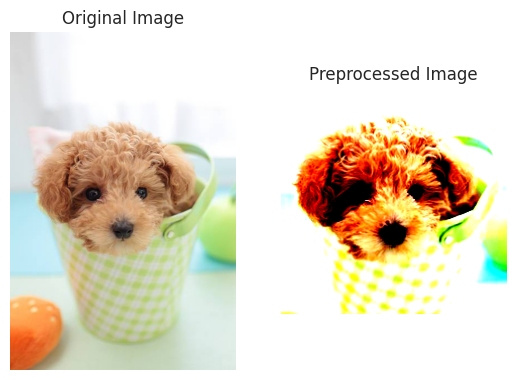

In [ ]:
"""
전처리를 거친 이미지는 다음과 같이 변환됩니다.
"""

original_image = train_dataset[3]['image']
preprocessed_image = feature_extractor(images=original_image)['pixel_values'][0].transpose(1,2,0)
print(f"전처리 전 이미지의 크기 : {np.array(original_image).shape}")
print(f"전처리 후 이미지의 크기 : {preprocessed_image.shape}")

"""
시각화하여 확인해보면 다음과 같습니다.
"""

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(preprocessed_image)
plt.axis('off')
plt.title("Preprocessed Image")


모델 입력 시 1) 이미지의 크기를 일정하도록 이미지 중앙부분을 중심으로 자르고 2) 입력값의 범위를 일정하도록 맞춰주는 작업을 수행하게 됩니다.
그 결과 위와 같이 원본 이미지와 다소 다른 모습을 확인할 수 있습니다.

이제 위와 같은 전처리를 거친 이미지를 모델 입력으로 사용 시 출력을 확인해보겠습니다.

In [ ]:
inputs = feature_extractor(images=original_image, return_tensors="pt") # 모델이 입력으로 받을 수 있는 Pytorch Tensor 형태로 변환합니다.
with torch.no_grad():
    outputs = model(**inputs) # 모델이 입력된 이미지에 대해 벡터 형태의 특징을 추출합니다.

print(f"특징 벡터의 형태 : {outputs.last_hidden_state.shape}")
last_hidden_states = outputs.pooler_output # 모델이 생성한 특징 벡터를 압축하여 2048차원의 벡터로 변환합니다.
print(f"압축된 특징 벡터의 형태 : {last_hidden_states.shape}")

특징 벡터의 형태 : torch.Size([1, 2048, 7, 7])
압축된 특징 벡터의 형태 : torch.Size([1, 2048, 1, 1])


## 1-4. 데이터 셋 구성
학습 데이터에 대해 labeled data와 unlabeled data를 구분하여 사용하겠습니다.
- labeled data: 전체 학습 데이터의 10%(210개)
- unlabeled data: 전체 학습 데이터의 90%(1890개)

In [ ]:
from datasets import concatenate_datasets
total_dataset = concatenate_datasets([dataset["train"], dataset["test"]])

In [ ]:
train_dataset = dataset['train'].train_test_split(test_size=0.9, seed=0, shuffle=True, stratify_by_column='label')
train_lab_dataset = train_dataset['train']
train_unlab_dataset = train_dataset['test']
test_dataset = dataset['test']

In [ ]:
print(f"Labeled Train 데이터셋의 크기 : {len(train_lab_dataset)}")
print(f"Unlabeled Train 데이터셋의 크기 : {len(train_unlab_dataset)}")
print(f"Test 데이터셋의 크기 : {len(test_dataset)}")

Labeled Train 데이터셋의 크기 : 210
Unlabeled Train 데이터셋의 크기 : 1890
Test 데이터셋의 크기 : 900


# 2. 공통 사용 함수 정의
## 2-1. 모델 클래스 정의

In [ ]:
class ResNetForImageClassification(nn.Module) :
    def __init__(self, backbone, num_labels=2) :
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(self.backbone.config.hidden_sizes[-1], num_labels)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.num_labels = num_labels

        self.id2label = {0 : "강아지", 1 : "음식"}

    def forward(self, pixel_values, label) :
        pixel_values = self.backbone(pixel_values).pooler_output.squeeze()
        logits = self.classifier(pixel_values)
        logits = self.softmax(logits,)

        preds = torch.argmax(logits, dim=-1).reshape(-1, 1)
        acc = accuracy_score(label.cpu().numpy(), preds.cpu().numpy())


        return {
            "prob" : logits,
            "representation" : pixel_values,
            "accrcacy": acc
            }

## 2-2. dataset 클래스 정의  
학습 시 사용될 데이터를 불러오는 클래스를 정의합니다.

In [ ]:
class DatasetBase(torch.utils.data.Dataset) :
    def __init__(self, dataset, augmentations=None) :
        self.dataset = dataset # 학습 데이터셋을 해당 클래스 내부에 저장합니다.
        self.augmentation = augmentations # 데이터 증강을 위한 augmentation 함수를 저장합니다.

    def __len__(self) :
        return len(self.dataset)

    def __getitem__(self, idx) : # 해당 메소드는 인덱스를 입력으로 받아 해당 인덱스에 위치한 데이터를 반환합니다.
        image = self.dataset[idx]['image'] # 해당 인덱스에 위치한 이미지를 불러옵니다.
        label = self.dataset[idx]['label'] # 해당 인덱스에 위치한 레이블을 불러옵니다.

        inputs = self.augmentation(image) # 입력된 이미지에 대해 augmentation을 적용합니다.

        sample = {}
        sample['pixel_values'] = inputs.squeeze() # 해당 이미지의 차원을 (RGB 채널, 이미지 높이, 이미지 너비)로 변경합니다.
        sample['labels'] = torch.tensor(label) # Loss 계산을 위해 레이블을 추가합니다.
        sample['idx'] = torch.tensor(idx) # 향후 분석을 위해 인덱스를 추가합니다.

        return sample

In [ ]:
class DatasetTwoAug(torch.utils.data.Dataset) : # 동일 이미지에 대해 두 가지 다른 augmentation을 적용하는 데이터셋 클래스입니다.
    def __init__(self, dataset, augmentations=None) :
        self.dataset = dataset
        self.augmentation = augmentations

    def __len__(self) :
        return len(self.dataset)

    def __getitem__(self, idx) :
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        inputs1 = self.augmentation(image) # 입력된 이미지에 대해 첫번째 augmentation을 적용합니다.
        inputs2 = self.augmentation(image) # 입력된 이미지에 대해 두번째 augmentation을 적용합니다.

        sample_1, sample_2 = {}, {}
        sample_1['pixel_values'] = inputs1.squeeze()
        sample_2['pixel_values'] = inputs2.squeeze()
        sample_1['labels'] = torch.tensor(label)
        sample_2['labels'] = torch.tensor(label)
        sample_1['idx'] = torch.tensor(idx)
        sample_2['idx'] = torch.tensor(idx)
        return sample_1, sample_2

In [ ]:
class DatasetWeakStrongAug(torch.utils.data.Dataset) : # 동일 이미지에 대해 두 가지 다른 augmentation 전략을 적용하는 데이터셋 클래스입니다.
    def __init__(self, dataset, aug_weak=None, aug_strong=None) :
        self.dataset = dataset
        self.aug_weak = aug_weak # 단순 augmentation 전략을 저장합니다.
        self.aug_strong = aug_strong # 강력한 augmentation 전략을 저장합니다.

    def __len__(self) :
        return len(self.dataset)

    def __getitem__(self, idx) :
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        inputs_weak = self.aug_weak(image) # 입력된 이미지에 대해 첫번째 augmentation을 적용합니다.
        inputs_strong = self.aug_strong(image) # 입력된 이미지에 대해 두번째 augmentation을 적용합니다.

        sample_weak, sample_strong = {}, {}
        sample_weak['pixel_values'] = inputs_weak.squeeze()
        sample_strong['pixel_values'] = inputs_strong.squeeze()
        sample_weak['labels'] = torch.tensor(label)
        sample_strong['labels'] = torch.tensor(label)
        sample_weak['idx'] = torch.tensor(idx)
        sample_strong['idx'] = torch.tensor(idx)
        return sample_weak, sample_strong

## 2-3 augmentation 함수 정의
데이터 증강을 위한 함수를 정의합니다.\
일반적인 이미지 도메인 모델은 기본적인 augmentation 기법을 사용합니다.\
이에 더해 semi-supervised learning 기법 중 일부(UDA)는 더욱 강한 augmentation 기법을 사용합니다.\
이번 실습에서는 두 augmentation을 통일하여, 방법론 별 성능 비교를 진행하겠습니다.\
이때 Strong Augmentation은 기본적인 augmentation과 더불어 강한 augmentation 기법들을 임의로 적용하는 Random Augmentation을 활용합니다.\
Radon Augmentation 기법에 대한 자세한 내용은 RandAugment: Practical automated data augmentation with a reduced search space
(https://arxiv.org/abs/1909.13719)을 참고하시면 됩니다.

In [ ]:
weak_aug = Compose([
        ToTensor(),
        ToDtype(torch.uint8, scale=True),
        RandomResizedCrop(224, scale=(0.5, 1.0), ratio=(0.75, 1.33)),
        RandomHorizontalFlip(),
        ToDtype(torch.float32, scale=True),
        # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

strong_aug = Compose([
        ToTensor(),
        ToDtype(torch.uint8, scale=True),
        RandomResizedCrop(224, scale=(0.5, 1.0), ratio=(0.75, 1.33)),
        RandomHorizontalFlip(),
        RandAugment(), # 해당 함수를 통해 다양한 augmentation을 임의로 적용하게 됩니다.
        ToDtype(torch.float32, scale=True),
        # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## 2-4. Loss 함수 정의
학습 시 사용될 Loss 함수를 정의합니다.\
이번 실습에서 사용될 Loss 함수는 아래와 같이 총 3가지 입니다.
- CrossEntropyLoss: Labeled Data에 대한 Loss, 일반적으로 분류 문제에서 사용됩니다.
- MeanSquaredError: Unlabeled Data에 대한 Loss, 두 Representation 간의 차이를 줄이기 위해 사용됩니다.
- KLDivergence: Unlabeled Data에 대한 Loss, 두 예측값 간의 차이를 줄이기 위해 사용됩니다. 수식을 간단히 하면 최종적으로는 CrossEntropyLoss와 같은 형태가 됩니다.

In [ ]:
def cross_entropy_loss(logits, labels) :
    return CrossEntropyLoss()(logits, labels)

def mse_loss(representation1, representation2) :
    return nn.MSELoss()(representation1, representation2)

def kl_divergence_loss(pseudo_label, aug_logits, mask) :
    loss_fn = nn.KLDivLoss(reduction='none', log_target=True)
    loss = torch.sum(loss_fn(aug_logits, pseudo_label), dim=-1)
    if torch.sum(mask) == 0 :
        return torch.tensor(0.0)
    else:
        loss = torch.sum(loss * mask, dim=-1) / torch.sum(mask, dim=-1) # mask를 이용하여 실제 사용될 pseudo label에 대해서만 loss를 계산합니다.
    return loss

# 3. 일반 학습 알고리즘 구현
일반적인 지도학습 방식의 알고리즘을 우선 구현하도록 하겠습니다\
지도학습 기반의 방법론은 unlabeled data를 사용하지 않고 labeled data만을 사용하여 학습을 진행합니다.\

In [ ]:
def train_iter_base(model, optimizer, sup_batch):
    sup_outputs = model(sup_batch['pixel_values'], sup_batch['labels']) # 지도 데이터에 대한 모델 출력을 계산합니다.
    sup_logits = sup_outputs['prob']
    sup_labels = sup_batch['labels']
    sup_loss = cross_entropy_loss(sup_logits, sup_labels) # 지도 데이터에 대한 Cross Entropy Loss를 계산합니다.

    optimizer.zero_grad()
    sup_loss.backward()
    optimizer.step()

    return {
        'total_loss': 0.0000,
        'sup_loss' : round(sup_loss.item(), 4),
        'sup_acc' : round(sup_outputs['accrcacy'], 4),
        'unsup_loss' : 0.0000,
        'unsup_acc' : 0.0000
        }

# 4. $\Pi$ Model 알고리즘 구현
$\Pi$ Model은 하나의 모델에 대해 두가지 Augmentation을 입력으로 받아 학습을 진행합니다.\
이때 두 Augmentation에 대한 Representation이 유사하도록 학습을 진행합니다.\

In [ ]:
def train_iter_pi(model, optimizer, sup_batch, unsup_batch1, unsup_batch2) :

    sup_outputs = model(sup_batch['pixel_values'], sup_batch['labels']) # 지도 데이터에 대한 모델 출력을 계산합니다.
    sup_logits = sup_outputs['prob']
    sup_labels = sup_batch['labels']
    sup_loss = cross_entropy_loss(sup_logits, sup_labels) # 지도 데이터에 대한 Cross Entropy Loss를 계산합니다.

    unsup_outputs_1 = model(unsup_batch1['pixel_values'], unsup_batch1['labels']) # 첫번째 augmentation에 대한 모델 출력을 계산합니다.
    unsup_repr_1 = unsup_outputs_1['representation']

    unsup_outputs_2 = model(unsup_batch2['pixel_values'], unsup_batch1['labels']) # 두번째 augmentation에 대한 모델 출력을 계산합니다.
    unsup_repr_2 = unsup_outputs_2['representation']

    unsup_loss = mse_loss(unsup_repr_1, unsup_repr_2) # 두 가지 augmentation에 대한 Representation 이 비슷하도록 유도하는 Loss를 계산합니다.

    loss = sup_loss + unsup_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return {
        'total_loss': round(loss.item(), 4),
        'sup_loss' : round(sup_loss.item(), 4),
        'sup_acc' : round(sup_outputs['accrcacy'], 4),
        'unsup_loss' : round(unsup_loss.item(), 4),
        'unsup_acc' : round(unsup_outputs_1['accrcacy'], 4)
        }

# 5. Mean Teacher 알고리즘 구현
Mean Teacher는 Student Model과 Teacher Model을 별도로 사용합니다.\
Teacher Model은 Student Model의 Weight를 Moving Averaging하여 사용합니다.\
이때 Student Model의 학습은 Labeled Data에 대한 CE Loss와 Unlabeled Data에 대한 MSE Loss를 통해 진행됩니다.\
unlabeld data에 대한 pseudo label은 Teacher Model의 예측을 사용합니다.

In [ ]:
# Student 모델의 현재 weight를 이용하여 Teacher 모델을 업데이트합니다.
def update_teacher_model(teacher_model, student_model, alpha=0.99) :
    for teacher_param, student_param in zip(teacher_model.parameters(), student_model.parameters()) :
        teacher_param.data = alpha * teacher_param.data + (1 - alpha) * student_param.data # Exponential Moving Average를 이용하여 Teacher 모델을 업데이트합니다.

In [ ]:
def train_iter_mt(student_model, teacher_model, optimizer, sup_batch, unsup_batch) :

    sup_outputs = student_model(sup_batch['pixel_values'], sup_batch['labels']) # 지도 데이터에 대한 모델 출력을 계산합니다.
    sup_logits = sup_outputs['prob']
    sup_labels = sup_batch['labels']
    sup_loss = cross_entropy_loss(sup_logits, sup_labels) # 지도 데이터에 대한 Cross Entropy Loss를 계산합니다.

    with torch.no_grad() : # Teacher 모델은 학습 대상이 아니므로 Gradient를 계산하지 않습니다.
        unsup_teacher_outputs = teacher_model(unsup_batch['pixel_values'], unsup_batch['labels'])
        unsup_teacher_probs = unsup_teacher_outputs['prob']# Teacher 모델의 출력을 Pseudo Label로 사용합니다.

    unsup_student_outputs = student_model(unsup_batch['pixel_values'], unsup_batch['labels'])  # Student 모델이 Unsupervised 데이터에 대한 출력을 계산합니다.
    unsup_student_probs = unsup_student_outputs['prob']

    unsup_loss = mse_loss(unsup_teacher_probs, unsup_student_probs) # Pseudo Label과 Student 모델의 출력 간의 MSE Loss를 계산합니다.

    loss = sup_loss + unsup_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return {
        'total_loss': round(loss.item(), 4),
        'sup_loss' : round(sup_loss.item(), 4),
        'sup_acc' : round(sup_outputs['accrcacy'], 4),
        'unsup_loss' : round(unsup_loss.item(), 4),
        'unsup_acc' : round(unsup_student_outputs['accrcacy'], 4)
        }

# 6. UDA 알고리즘 구현
UDA는 Labeled Data에 대한 CE Loss와 Unlabeled Data에 대한 Consistency Loss를 통해 학습을 진행합니다.\
Consistency Loss는 두가지 Augmentation에 대한 예측값의 차이를 줄이기 위해 사용됩니다.\
이때 두 예측값이 같은 분포를 가지도록 학습을 진행합니다.

In [ ]:
def train_iter_uda(model, optimizer, sup_batch, unsup_batch_weak, unsup_batch_strong, threshold= 0.9) :

    sup_outputs = model(sup_batch['pixel_values'], sup_batch['labels']) # 지도 데이터에 대한 모델 출력을 계산합니다.
    sup_logits = sup_outputs['prob']
    sup_labels = sup_batch['labels']
    sup_loss = cross_entropy_loss(sup_logits, sup_labels) # 지도 데이터에 대한 Cross Entropy Loss를 계산합니다.

    with torch.no_grad():
        unsup_weak_outputs = model(unsup_batch_weak['pixel_values'], unsup_batch_weak['labels']) # 약한 augmentation에 대한 모델 출력을 계산합니다.
        unsup_weak_logits = unsup_weak_outputs['prob']
        unsup_loss_mask = torch.max(torch.exp(unsup_weak_logits), dim=-1)[0] > threshold # 모델이 확신을 가지고 예측한 데이터에 대해서만 pseudo label을 생성합니다.
        unsup_loss_mask = unsup_loss_mask.type(torch.float32)

    unsup_strong_outputs = model(unsup_batch_strong['pixel_values'], unsup_batch_strong['labels']) # 강한 augmentation에 대한 모델 출력을 계산합니다.
    unsup_strong_logits = unsup_strong_outputs['prob']
    unsup_loss = kl_divergence_loss(unsup_weak_logits, unsup_strong_logits, mask=unsup_loss_mask) # 두 가지 augmentation에 대한 KL Divergence Loss를 계산합니다.

    loss = sup_loss + unsup_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return {
        'total_loss': round(loss.item(), 4),
        'sup_loss' : round(sup_loss.item(), 4),
        'sup_acc' : round(sup_outputs['accrcacy'], 4),
        'unsup_loss' : round(unsup_loss.item(), 4),
        'unsup_acc' : round(unsup_weak_outputs['accrcacy'], 4)
        }

# 7. 전체 학습 파이프라인 구현
각 방법론에 대한 학습 파이프라인을 구현합니다.\
이때, 실제 각 방법론들은 labeled 데이터와 unlabeled 데이터를 별도로 활용하기 때문에, 동일한 학습 파이프라인을 사용할 수 있습니다.\
하나의 파이프라인을 이용하여 각 방법론을 실험할 수 있도록 전체 학습 파이프라인을 구현해보겠습니다.

In [ ]:
def move_to_device(batch, device) :
    for key in batch.keys() :
        batch[key] = batch[key].to(device)
    return batch

In [ ]:
def train(train_labeled_dataset, train_unlabeled_dataset, method, train_step = 1000) :
    train_log = {}
    if method == "pi" :
        train_iter_fn = train_iter_pi
    elif method == "mt" :
        train_iter_fn = train_iter_mt
    elif method == "uda" :
        train_iter_fn = train_iter_uda
    else:
        train_iter_fn = train_iter_base

    config = AutoConfig.from_pretrained("microsoft/resnet-18", output_hidden_states=True)
    model = AutoModel.from_config(config)
    model = ResNetForImageClassification(model).cuda()

    if method == "mt" :
        teacher_model = AutoModel.from_config(config)
        teacher_model = ResNetForImageClassification(teacher_model).cuda()
        teacher_model.load_state_dict(model.state_dict())

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

    if method == "base_full" :
        from datasets import concatenate_datasets
        train_labeled_dataset = concatenate_datasets([train_labeled_dataset, train_unlabeled_dataset])
    labeled_dataset = DatasetBase(train_labeled_dataset, augmentations=weak_aug)
    if method == "pi" :
        unlabeled_dataset = DatasetTwoAug(train_unlabeled_dataset, augmentations=weak_aug)
    elif method == "mt" :
        unlabeled_dataset = DatasetBase(train_unlabeled_dataset, augmentations=weak_aug)
    elif method == "uda" :
        unlabeled_dataset = DatasetWeakStrongAug(train_unlabeled_dataset, aug_weak=weak_aug, aug_strong=strong_aug)

    labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=16, shuffle=True, pin_memory=True)
    labeled_data_iterator = iter(labeled_loader)

    if not "base" in method :
        unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=16, shuffle=True, pin_memory=True)
        unlabeled_data_iterator = iter(unlabeled_loader)

    step_counter = tqdm(range(train_step), desc="Training", position=0, leave=True)
    step = 0
    while step < train_step :
        step += 1
        step_counter.update(1)
        try:
            sup_batch = next(labeled_data_iterator)
        except StopIteration:
            labeled_data_iterator = iter(labeled_loader)
            sup_batch = next(labeled_data_iterator)

        if not "base" in method:
            try:
                unsup_batch = next(unlabeled_data_iterator)
            except StopIteration:
                unlabeled_data_iterator = iter(unlabeled_loader)
                unsup_batch = next(unlabeled_data_iterator)

        sup_batch = move_to_device(sup_batch, model.backbone.device)

        if method == "pi" :
            unsup_batch1, unsup_batch2 = unsup_batch
            unsup_batch1 = move_to_device(unsup_batch1, model.backbone.device)
            unsup_batch2 = move_to_device(unsup_batch2, model.backbone.device)
            result = train_iter_fn(model, optimizer, sup_batch, unsup_batch1, unsup_batch2)
        if method == "mt" :
            unsup_batch = move_to_device(unsup_batch, model.backbone.device)
            result = train_iter_fn(model, teacher_model, optimizer, sup_batch, unsup_batch)
        if method == "uda" :
            unsup_batch_weak, unsup_batch_strong = unsup_batch
            unsup_batch_weak = move_to_device(unsup_batch_weak, model.backbone.device)
            unsup_batch_strong = move_to_device(unsup_batch_strong, model.backbone.device)
            result = train_iter_fn(model, optimizer, sup_batch, unsup_batch_weak, unsup_batch_strong)
        if "base" in method :
            result = train_iter_fn(model, optimizer, sup_batch)

        train_log[step] = result
        if step % 10 == 0 :
            print(f"Step : {step:5} | Loss : {result['total_loss']:.4f} | Sup Loss : {result['sup_loss']:.4f} | Unsup Loss : {result['unsup_loss']:.4f} | Sup Acc : {result['sup_acc']:.4f} | Unsup Acc : {result['unsup_acc']:.4f}")

        if method == "mt" :
            update_teacher_model(teacher_model, model)

    return model, train_log

In [ ]:
pi_model, pi_train_log = train(train_lab_dataset, train_unlab_dataset, "pi", train_step = 100)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Step :    10 | Loss : 0.5278 | Sup Loss : 0.4802 | Unsup Loss : 0.0476 | Sup Acc : 0.6875 | Unsup Acc : 0.9375
Step :    20 | Loss : 0.4781 | Sup Loss : 0.4465 | Unsup Loss : 0.0316 | Sup Acc : 0.8125 | Unsup Acc : 0.6875
Step :    30 | Loss : 0.3816 | Sup Loss : 0.3493 | Unsup Loss : 0.0323 | Sup Acc : 0.8125 | Unsup Acc : 0.8125
Step :    40 | Loss : 0.4659 | Sup Loss : 0.4309 | Unsup Loss : 0.0351 | Sup Acc : 0.8125 | Unsup Acc : 0.6250
Step :    50 | Loss : 0.6267 | Sup Loss : 0.5974 | Unsup Loss : 0.0293 | Sup Acc : 0.6875 | Unsup Acc : 0.8750
Step :    60 | Loss : 0.3954 | Sup Loss : 0.3633 | Unsup Loss : 0.0321 | Sup Acc : 0.8125 | Unsup Acc : 0.8750
Step :    70 | Loss : 0.3917 | Sup Loss : 0.3642 | Unsup Loss : 0.0275 | Sup Acc : 1.0000 | Unsup Acc : 0.8125
Step :    80 | Loss : 0.2611 | Sup Loss : 0.2309 | Unsup Loss : 0.0302 | Sup Acc : 0.9375 | Unsup Acc : 0.6875
Step :    90 | Loss : 0.2748 | Sup Loss : 0.2451 | Unsup Loss : 0.0298 | Sup Acc : 0.8750 | Unsup Acc : 0.7500
S

In [ ]:
mt_model, mt_train_log = train(train_lab_dataset, train_unlab_dataset, "mt", train_step = 100)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Step :    10 | Loss : 0.5813 | Sup Loss : 0.5703 | Unsup Loss : 0.0110 | Sup Acc : 0.6250 | Unsup Acc : 0.7500
Step :    20 | Loss : 0.5469 | Sup Loss : 0.4998 | Unsup Loss : 0.0472 | Sup Acc : 0.7500 | Unsup Acc : 0.8125
Step :    30 | Loss : 0.6223 | Sup Loss : 0.6042 | Unsup Loss : 0.0181 | Sup Acc : 0.6875 | Unsup Acc : 0.5000
Step :    40 | Loss : 0.5300 | Sup Loss : 0.5053 | Unsup Loss : 0.0247 | Sup Acc : 0.8750 | Unsup Acc : 0.7500
Step :    50 | Loss : 0.5802 | Sup Loss : 0.5306 | Unsup Loss : 0.0496 | Sup Acc : 0.6875 | Unsup Acc : 0.8750
Step :    60 | Loss : 0.5813 | Sup Loss : 0.5602 | Unsup Loss : 0.0211 | Sup Acc : 0.5625 | Unsup Acc : 0.8750
Step :    70 | Loss : 0.5562 | Sup Loss : 0.5234 | Unsup Loss : 0.0328 | Sup Acc : 0.5000 | Unsup Acc : 0.6875
Step :    80 | Loss : 0.4865 | Sup Loss : 0.4741 | Unsup Loss : 0.0123 | Sup Acc : 0.8125 | Unsup Acc : 0.7500
Step :    90 | Loss : 0.5081 | Sup Loss : 0.4655 | Unsup Loss : 0.0426 | Sup Acc : 0.8125 | Unsup Acc : 0.9375
S

In [ ]:
uda_model, uda_train_log = train(train_lab_dataset, train_unlab_dataset, "uda", train_step = 100)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Step :    10 | Loss : 0.3734 | Sup Loss : 0.3503 | Unsup Loss : 0.0231 | Sup Acc : 0.8750 | Unsup Acc : 0.8125
Step :    20 | Loss : 0.4485 | Sup Loss : 0.4481 | Unsup Loss : 0.0004 | Sup Acc : 0.8125 | Unsup Acc : 0.6875
Step :    30 | Loss : 0.3510 | Sup Loss : 0.2395 | Unsup Loss : 0.1115 | Sup Acc : 0.9375 | Unsup Acc : 0.8750
Step :    40 | Loss : 0.7158 | Sup Loss : 0.6357 | Unsup Loss : 0.0801 | Sup Acc : 0.5625 | Unsup Acc : 0.9375
Step :    50 | Loss : 0.6625 | Sup Loss : 0.2018 | Unsup Loss : 0.4607 | Sup Acc : 0.9375 | Unsup Acc : 0.8750
Step :    60 | Loss : 0.8918 | Sup Loss : 0.8224 | Unsup Loss : 0.0694 | Sup Acc : 0.5625 | Unsup Acc : 0.9375
Step :    70 | Loss : 1.7730 | Sup Loss : 1.7679 | Unsup Loss : 0.0051 | Sup Acc : 0.0000 | Unsup Acc : 0.7500
Step :    80 | Loss : 0.2666 | Sup Loss : 0.2448 | Unsup Loss : 0.0218 | Sup Acc : 0.8750 | Unsup Acc : 0.8750
Step :    90 | Loss : 0.5290 | Sup Loss : 0.4261 | Unsup Loss : 0.1029 | Sup Acc : 0.6875 | Unsup Acc : 0.8125
S

In [ ]:
base_small_model, base_small_log = train(train_lab_dataset, train_unlab_dataset, "base_small", train_step = 100)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Step :    10 | Loss : 0.0000 | Sup Loss : 0.4261 | Unsup Loss : 0.0000 | Sup Acc : 0.7500 | Unsup Acc : 0.0000
Step :    20 | Loss : 0.0000 | Sup Loss : 0.4353 | Unsup Loss : 0.0000 | Sup Acc : 0.7500 | Unsup Acc : 0.0000
Step :    30 | Loss : 0.0000 | Sup Loss : 0.3002 | Unsup Loss : 0.0000 | Sup Acc : 0.8125 | Unsup Acc : 0.0000
Step :    40 | Loss : 0.0000 | Sup Loss : 0.5227 | Unsup Loss : 0.0000 | Sup Acc : 0.5625 | Unsup Acc : 0.0000
Step :    50 | Loss : 0.0000 | Sup Loss : 0.4382 | Unsup Loss : 0.0000 | Sup Acc : 0.8125 | Unsup Acc : 0.0000
Step :    60 | Loss : 0.0000 | Sup Loss : 0.2224 | Unsup Loss : 0.0000 | Sup Acc : 0.9375 | Unsup Acc : 0.0000
Step :    70 | Loss : 0.0000 | Sup Loss : 0.5390 | Unsup Loss : 0.0000 | Sup Acc : 0.5000 | Unsup Acc : 0.0000
Step :    80 | Loss : 0.0000 | Sup Loss : 0.2294 | Unsup Loss : 0.0000 | Sup Acc : 0.8750 | Unsup Acc : 0.0000
Step :    90 | Loss : 0.0000 | Sup Loss : 0.2695 | Unsup Loss : 0.0000 | Sup Acc : 0.8750 | Unsup Acc : 0.0000
S

In [ ]:
base_full_model, base_full_log = train(train_lab_dataset, train_unlab_dataset, "base_full", train_step = 500)

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Step :    10 | Loss : 0.0000 | Sup Loss : 0.3984 | Unsup Loss : 0.0000 | Sup Acc : 0.8125 | Unsup Acc : 0.0000
Step :    20 | Loss : 0.0000 | Sup Loss : 0.7381 | Unsup Loss : 0.0000 | Sup Acc : 0.6250 | Unsup Acc : 0.0000
Step :    30 | Loss : 0.0000 | Sup Loss : 0.4213 | Unsup Loss : 0.0000 | Sup Acc : 0.8125 | Unsup Acc : 0.0000
Step :    40 | Loss : 0.0000 | Sup Loss : 0.3316 | Unsup Loss : 0.0000 | Sup Acc : 0.8750 | Unsup Acc : 0.0000
Step :    50 | Loss : 0.0000 | Sup Loss : 0.4117 | Unsup Loss : 0.0000 | Sup Acc : 0.6875 | Unsup Acc : 0.0000
Step :    60 | Loss : 0.0000 | Sup Loss : 0.3456 | Unsup Loss : 0.0000 | Sup Acc : 0.9375 | Unsup Acc : 0.0000
Step :    70 | Loss : 0.0000 | Sup Loss : 0.3035 | Unsup Loss : 0.0000 | Sup Acc : 0.9375 | Unsup Acc : 0.0000
Step :    80 | Loss : 0.0000 | Sup Loss : 0.2578 | Unsup Loss : 0.0000 | Sup Acc : 0.9375 | Unsup Acc : 0.0000
Step :    90 | Loss : 0.0000 | Sup Loss : 0.3496 | Unsup Loss : 0.0000 | Sup Acc : 0.8750 | Unsup Acc : 0.0000
S

# 8. 방법론 평가

In [ ]:
def test(model) :
    model.eval()
    test_Dataset = DatasetBase(test_dataset, augmentations=Compose([ToTensor(), Resize((224,224)), ToDtype(torch.float32, scale=True)]))
    test_dataloader = torch.utils.data.DataLoader(test_Dataset, batch_size=16, shuffle=False)
    labels = []
    preds = []
    for test_batch in test_dataloader :
        test_batch = move_to_device(test_batch, model.backbone.device)
        with torch.no_grad() :
            outputs = model(test_batch['pixel_values'], test_batch['labels'])
            label = test_batch['labels']
            pred = torch.argmax(outputs['prob'], dim=-1)
            labels.extend(label.cpu().numpy())
            preds.extend(pred.cpu().numpy())
    acc_log = accuracy_score(labels, preds)
    f1_score_log = f1_score(labels, preds, average='macro')
    result = {"accuracy" : acc_log, "f1_score" : f1_score_log}
    return result

In [ ]:
test_log = {}
for model, method in zip([pi_model, mt_model, uda_model, base_small_model, base_full_model], ["pi", "mt", "uda", "base_small", "base_full"]) :
    result = test(model)
    test_log[method] = result

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and

In [ ]:
pd.DataFrame(test_log)

,pi,mt,uda,base_small,base_full
accuracy,0.806667,0.785556,0.707778,0.835556,0.765556
f1_score,0.794380,0.710171,0.702216,0.822967,0.762565


### 1000 step 학습 시 성능

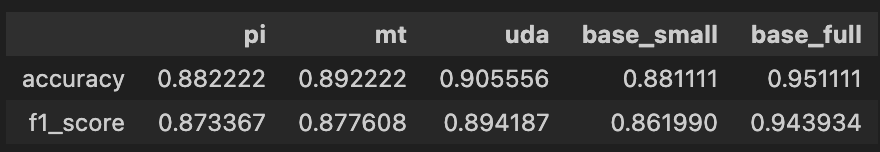

# 9. 학습과정 분석
각 방법론의 학습 과정을 살펴보면서 unlabeled 데이터가 이용되었는지 확인해보도록 하겠습니다.

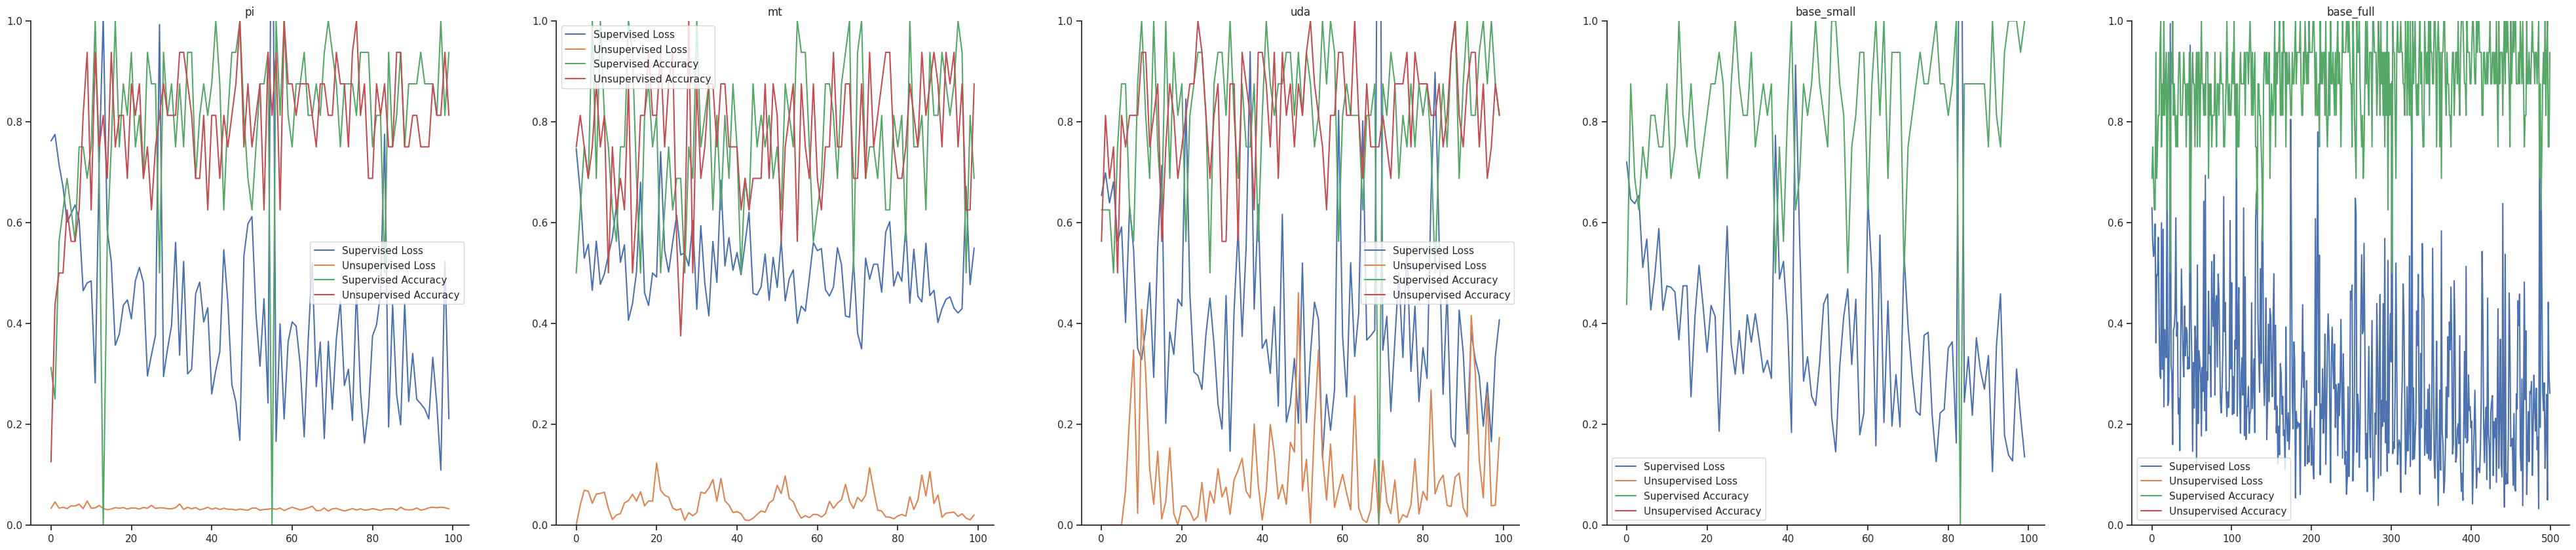

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(50, 10))
# plot sup and unsup loss
for i, (model, method) in enumerate(zip([pi_model, mt_model, uda_model, base_small_model, base_full_model], ["pi", "mt", "uda", "base_small", "base_full"])) :
    train_log = pi_train_log if method == "pi" else mt_train_log if method == "mt" else uda_train_log if method == "uda" else base_small_log if method == "base_small" else base_full_log
    sup_loss = [log['sup_loss'] for log in train_log.values()]
    unsup_loss = [log['unsup_loss'] for log in train_log.values()]
    sup_acc = [log['sup_acc'] for log in train_log.values()]
    unsup_acc = [log['unsup_acc'] for log in train_log.values()]

    axs[i].plot(sup_loss, label="Supervised Loss")
    axs[i].plot(unsup_loss, label="Unsupervised Loss")
    axs[i].plot(sup_acc, label="Supervised Accuracy")
    axs[i].plot(unsup_acc, label="Unsupervised Accuracy")
    axs[i].set_title(f"{method}")
    axs[i].set_ylim(0, 1)
    axs[i].legend()

위 결과와 실제 각 방법론 별 성능을 함께 고려할 때 다음과 같이 정리할 수 있습니다.
- Mean teacher와 $\Pi$ Model은 Unlabeled Data로 부터 발생하는 loss가 매우 작은 모습
- Mean teacher와 $\Pi$ Model은 매우 완만히 Labeled Data에 대한 정확도가 상승
- UDA는 Unlabeled Data에 대한 loss가 크게 발생하며, 이를 통해 label이 없는 데이터에 대해서도 정보 학습
- 실제 학습 과정 중의 accuracy와 학습 정도를 비례하여 확인할 수 없음.

# 10. UDA 학습 정도별 성능 및 분석
마지막으로 UDA 모델에 대해 학습 step 별 성능을 분석하고 마무리하도록 하겠습니다. 이를 위해 학습 함수를 조금 수정하겠습니다.

In [ ]:
from copy import deepcopy

In [ ]:
def train(train_labeled_dataset, train_unlabeled_dataset, method, train_step = 1000) :
    model_log = {} # 학습 스텝 별 모델을 저장할 dictionary 입니다.
    train_log = {}
    if method == "pi" :
        train_iter_fn = train_iter_pi
    elif method == "mt" :
        train_iter_fn = train_iter_mt
    elif method == "uda" :
        train_iter_fn = train_iter_uda
    else:
        train_iter_fn = train_iter_base

    config = AutoConfig.from_pretrained("microsoft/resnet-18", output_hidden_states=True)
    model = AutoModel.from_config(config)
    model = ResNetForImageClassification(model).cuda()

    if method == "mt" :
        teacher_model = AutoModel.from_config(config)
        teacher_model = ResNetForImageClassification(teacher_model).cuda()
        teacher_model.load_state_dict(model.state_dict())

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

    if method == "base_full" :
        from datasets import concatenate_datasets
        train_labeled_dataset = concatenate_datasets([train_labeled_dataset, train_unlabeled_dataset])
    labeled_dataset = DatasetBase(train_labeled_dataset, augmentations=weak_aug)
    if method == "pi" :
        unlabeled_dataset = DatasetTwoAug(train_unlabeled_dataset, augmentations=weak_aug)
    elif method == "mt" :
        unlabeled_dataset = DatasetBase(train_unlabeled_dataset, augmentations=weak_aug)
    elif method == "uda" :
        unlabeled_dataset = DatasetWeakStrongAug(train_unlabeled_dataset, aug_weak=weak_aug, aug_strong=strong_aug)

    labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=16, shuffle=True)
    labeled_data_iterator = iter(labeled_loader)

    if not "base" in method :
        unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=16, shuffle=True)
        unlabeled_data_iterator = iter(unlabeled_loader)

    step_counter = tqdm(range(train_step), desc="Training", position=0, leave=True)
    step = 0
    while step < train_step :
        step += 1
        step_counter.update(1)
        try:
            sup_batch = next(labeled_data_iterator)
        except StopIteration:
            labeled_data_iterator = iter(labeled_loader)
            sup_batch = next(labeled_data_iterator)

        if not "base" in method:
            try:
                unsup_batch = next(unlabeled_data_iterator)
            except StopIteration:
                unlabeled_data_iterator = iter(unlabeled_loader)
                unsup_batch = next(unlabeled_data_iterator)

        sup_batch = move_to_device(sup_batch, model.backbone.device)

        if method == "pi" :
            unsup_batch1, unsup_batch2 = unsup_batch
            unsup_batch1 = move_to_device(unsup_batch1, model.backbone.device)
            unsup_batch2 = move_to_device(unsup_batch2, model.backbone.device)
            result = train_iter_fn(model, optimizer, sup_batch, unsup_batch1, unsup_batch2)
        if method == "mt" :
            unsup_batch = move_to_device(unsup_batch, model.backbone.device)
            result = train_iter_fn(model, teacher_model, optimizer, sup_batch, unsup_batch)
        if method == "uda" :
            unsup_batch_weak, unsup_batch_strong = unsup_batch
            unsup_batch_weak = move_to_device(unsup_batch_weak, model.backbone.device)
            unsup_batch_strong = move_to_device(unsup_batch_strong, model.backbone.device)
            result = train_iter_fn(model, optimizer, sup_batch, unsup_batch_weak, unsup_batch_strong)
        if "base" in method :
            result = train_iter_fn(model, optimizer, sup_batch)

        if step % 10 == 0 :
            print(f"Step : {step:5} | Loss : {result['total_loss']:.4f} | Sup Loss : {result['sup_loss']:.4f} | Unsup Loss : {result['unsup_loss']:.4f} | Sup Acc : {result['sup_acc']:.4f} | Unsup Acc : {result['unsup_acc']:.4f}")
        train_log[step] = result

        if (step+1) % 100 == 0:
            model_log[step] = deepcopy(model)

    model_log[step] = deepcopy(model)

    return model_log, train_log

In [ ]:
uda_model_log, uda_train_log = train(train_lab_dataset, train_unlab_dataset, "uda", train_step = 1000)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step :    10 | Loss : 0.7364 | Sup Loss : 0.6951 | Unsup Loss : 0.0414 | Sup Acc : 0.5625 | Unsup Acc : 0.5625
Step :    20 | Loss : 0.4449 | Sup Loss : 0.3200 | Unsup Loss : 0.1249 | Sup Acc : 0.8750 | Unsup Acc : 0.7500
Step :    30 | Loss : 0.3489 | Sup Loss : 0.3436 | Unsup Loss : 0.0053 | Sup Acc : 0.8125 | Unsup Acc : 0.8750
Step :    40 | Loss : 0.2555 | Sup Loss : 0.2147 | Unsup Loss : 0.0408 | Sup Acc : 1.0000 | Unsup Acc : 0.9375
Step :    50 | Loss : 0.6530 | Sup Loss : 0.5581 | Unsup Loss : 0.0948 | Sup Acc : 0.8125 | Unsup Acc : 0.8125
Step :    60 | Loss : 0.2226 | Sup Loss : 0.2043 | Unsup Loss : 0.0183 | Sup Acc : 1.0000 | Unsup Acc : 0.7500
Step :    70 | Loss : 0.3267 | Sup Loss : 0.3027 | Unsup Loss : 0.0240 | Sup Acc : 1.0000 | Unsup Acc : 0.6875
Step :    80 | Loss : 0.2614 | Sup Loss : 0.1881 | Unsup Loss : 0.0734 | Sup Acc : 1.0000 | Unsup Acc : 0.6250
Step :    90 | Loss : 0.3804 | Sup Loss : 0.3058 | Unsup Loss : 0.0745 | Sup Acc : 0.8750 | Unsup Acc : 0.8750
S

In [ ]:
test_log = {}
for step, model in uda_model_log.items():
    result = test(model)
    test_log[step] = result

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and

In [ ]:
pd.DataFrame(test_log)

,99,199,299,399,499,599,699,799,899,999,1000
accuracy,0.856667,0.868889,0.854444,0.85000,0.892222,0.874444,0.905556,0.883333,0.847778,0.890000,0.883333
f1_score,0.821604,0.836211,0.843201,0.80747,0.872097,0.860231,0.890575,0.857202,0.839618,0.872308,0.862685


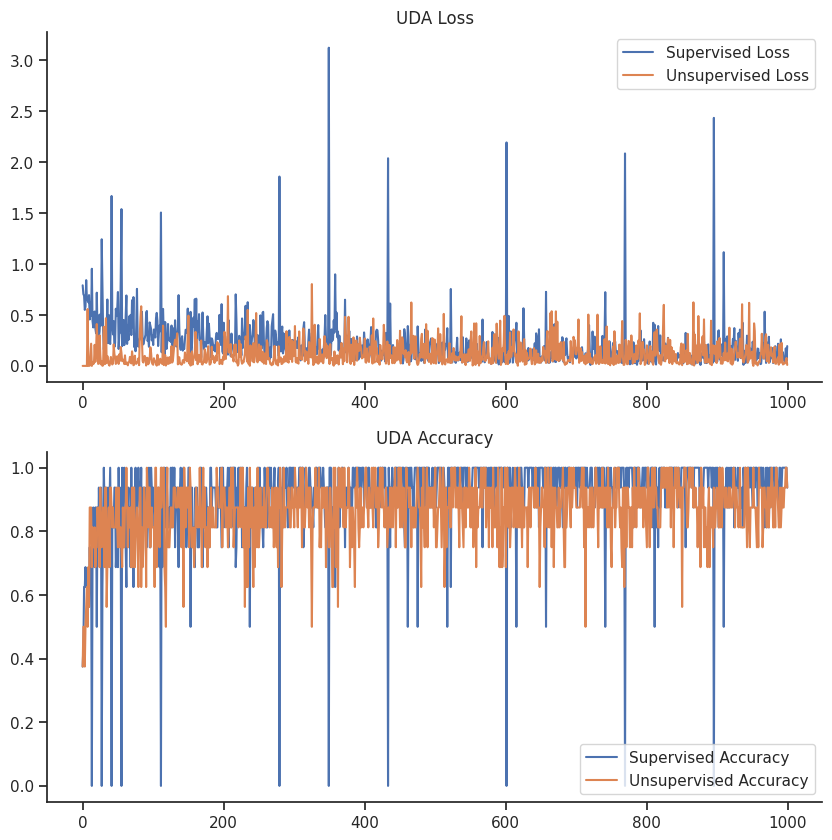

In [ ]:
# plot train log
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# plot sup and unsup loss
sup_loss = [log['sup_loss'] for log in uda_train_log.values()]
unsup_loss = [log['unsup_loss'] for log in uda_train_log.values()]
sup_acc = [log['sup_acc'] for log in uda_train_log.values()]
unsup_acc = [log['unsup_acc'] for log in uda_train_log.values()]

axs[0].plot(sup_loss, label="Supervised Loss")
axs[0].plot(unsup_loss, label="Unsupervised Loss")
axs[0].set_title("UDA Loss")
axs[0].legend()

# plot accuracy
axs[1].plot(sup_acc, label="Supervised Accuracy")
axs[1].plot(unsup_acc, label="Unsupervised Accuracy")
axs[1].set_title("UDA Accuracy")
axs[1].legend()

